## Bayesian inference of Spanish High Speed Rail tickets pricing 
<t>A kaggle competition https://www.kaggle.com/thegurus/spanish-high-speed-rail-system-ticket-pricing</t>  
<b>Ref</b>: https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

### Bayesian tools used

1.PyMC3: a Python library for probabilistic programming(Bayesian inference).https://docs.pymc.io/    
2.ArviZ: a Python library for exploratory analysis of Bayesian models.https://arviz-devs.github.io/arviz/  


In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print('Running on PyMC3 v{}'.format(pm.__version__))
data = pd.read_csv('dataset.csv')
print("original size of dataset:",data.size)
data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac=0.01, random_state=99)
print("sample size of dataset:",data.size)
data.head()

Running on PyMC3 v3.7
original size of dataset: 25797710
sample size of dataset: 232182


,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
420104,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
431888,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
791293,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
678876,2019-04-24 06:21:57,SEVILLA,MADRID,2019-05-03 08:35:00,2019-05-03 15:26:00,LD-MD,34.35,Turista con enlace,Promo +
86381,2019-04-19 21:13:55,VALENCIA,MADRID,2019-05-10 09:40:00,2019-05-10 11:20:00,AVE,45.30,Turista,Promo


Checking for any missing values in our data set

In [3]:
data.isnull().sum()/len(data)#about ~12% of price values are NaN(missing)NaN stands for not a number/undefined

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

<b>Imputation</b> : Circumventing the above problem of missing values using mean values for continuos variable(s) and mode for categorical variable(s)

In [4]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])#categorical variables
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])#categorical variables
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))#continuous variable

checking our data set again to make sure that <b>all</b> values have been imputed in our dataset.

In [5]:
data.isnull().sum()/len(data)

insert_date    0.0
origin         0.0
destination    0.0
start_date     0.0
end_date       0.0
train_type     0.0
price          0.0
train_class    0.0
fare           0.0
dtype: float64

([<matplotlib.axis.YTick at 0x7f66adddd6a0>],
 <a list of 1 Text yticklabel objects>)

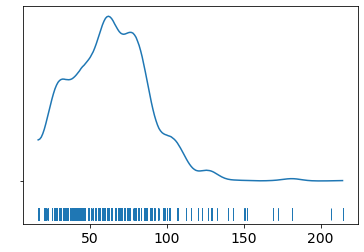

In [6]:
az.plot_kde(data['price'].values, rug=True)#kde:kernel density estimation,a function of seaborn;used by arviz
plt.yticks([0], alpha=0)

<b>Selecting a prior</b>: Since the plot of the "price"-- our latent variable -- that is to be predicted has a sort of bell shape we shall use Gaussian prior.  
Also,since we do not know the mean or the standard deviation for the gaussian prior, we must set priors for both of them.

### Gaussian prior.

In [7]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', lower=0, upper=300)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)
#No U-Turn Sampler (NUTS) is a Hamiltonian/Hybrid Monte Carlo Method(MCMC Sampling for approximating posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 568.70draws/s]
The acceptance probability does not match the target. It is 0.8824604078676586, but should be close to 0.8. Try to increase the number of tuning steps.


### Gamma prior

In [16]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', lower=0, upper=300)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Gamma('y', mu=mu, sd=sigma, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:44<00:00, 89.78draws/s] 
The acceptance probability does not match the target. It is 0.9781469364870069, but should be close to 0.8. Try to increase the number of tuning steps.


### These are marginal plots assuming Gamma prior

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f668015ecf8>,
      dtype=object)

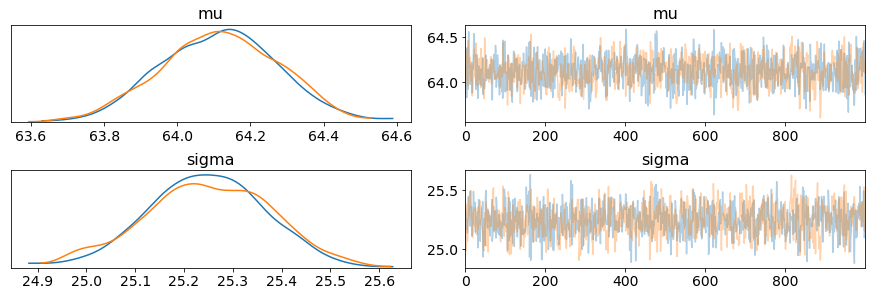

In [17]:
az.plot_trace(trace_g)

### This is a joint plot of mu and sigma for Gamma prior

(<matplotlib.axes._subplots.AxesSubplot at 0x7f667ffa57b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f667ff4e8d0>)

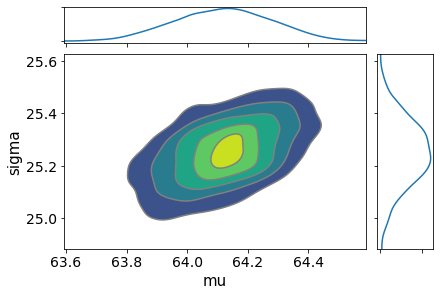

In [18]:
az.plot_joint(trace_g, kind='kde', fill_last=False)

This is a visual summary of <b>posterior</b> distribution for Gamma prior

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f669ccc6cc0>,
      dtype=object)

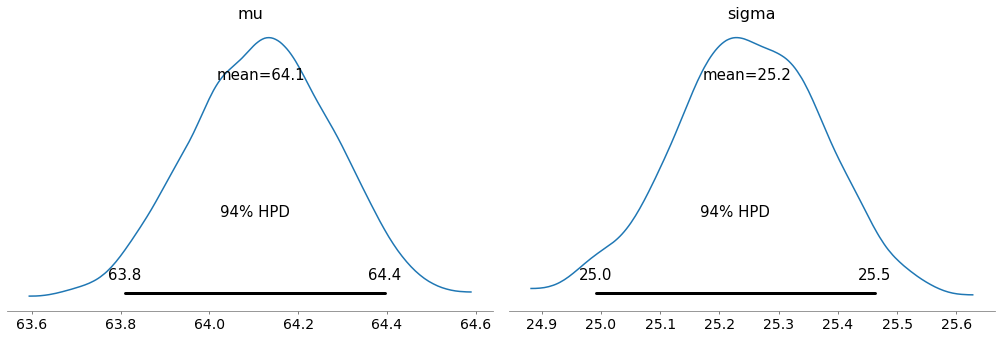

In [19]:
az.plot_posterior(trace_g)

###  These are marginal plots assuming Gaussian prior

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f669ddf9908>,
      dtype=object)

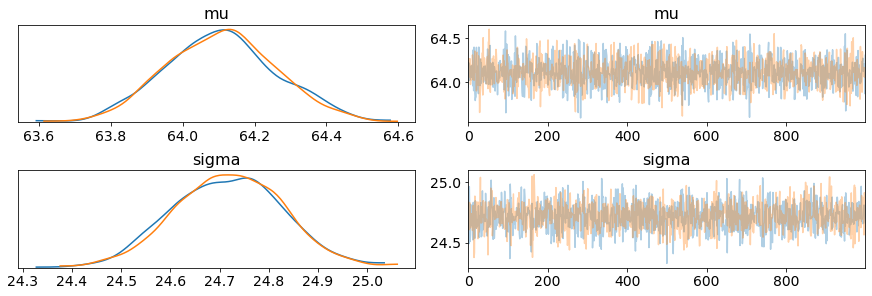

In [8]:
az.plot_trace(trace_g)

### This is a joint plot of mu and sigma for Gaussian prior

(<matplotlib.axes._subplots.AxesSubplot at 0x7f669ccc2400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f669cc3d9e8>)

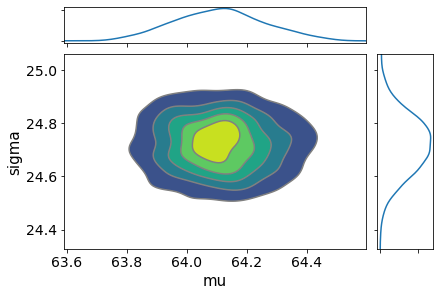

In [9]:
az.plot_joint(trace_g, kind='kde', fill_last=False)

This is a summary of <b>Posterior distribution</b> for each: mu and sigma ,assuming Gamma prior

In [10]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,64.107,0.154,63.798,64.374,0.003,0.002,2157.0,2157.0,2154.0,1467.0,1.0
sigma,24.718,0.111,24.515,24.924,0.002,0.002,1997.0,1995.0,2011.0,1423.0,1.0


This is a <i>visual</i> summary of <b>Posterior distribution</b> for each: mu and sigma as we seen above

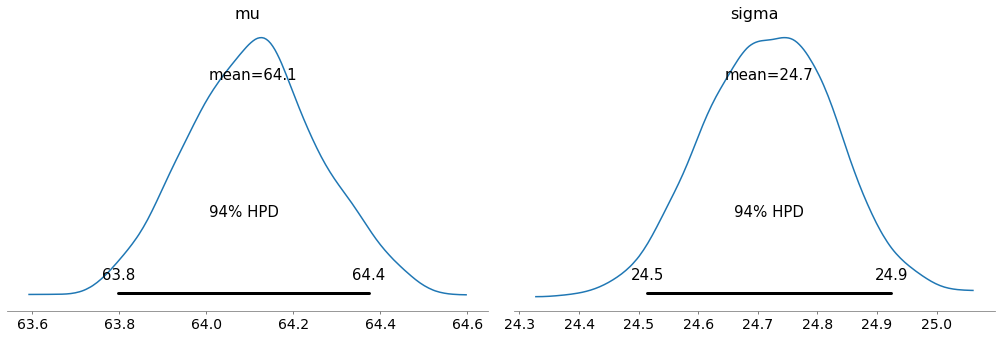

In [11]:
az.plot_posterior(trace_g);

<b>Remarks: </b>  
1.Unlike frequentist approach where we obtain point estimates, in bayesian approach we obtain the entire posterior distribution of the uncertain quantity(hidden/latent variable.Eg:In our case the price)  
2.The intervals in bayesian inference reflect the inherent meaning of any trite interval i.e. <i>to contain the element of interest(unknown parameter)</i> unlike the frequentists where the inuition of <i>confidence intervals</i> would infer the probability of the unknown parameter being contained in the interval at that confidence level if sampling were to be performed from a population.



#### Confirming convergence of the markov chains of sampling to a target posterior distribution

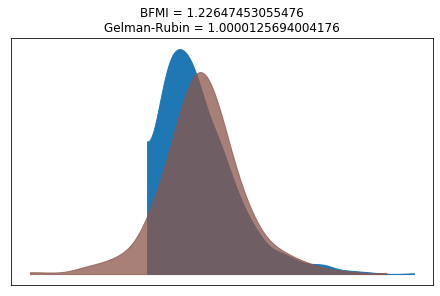

In [12]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_g).values())
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

### Validating a model using predictive posterior distribution p(x*|x)
i.e. to generate(predict/forecast) data from the model using the parameters that our posterior distribution computed hitherto.

The following function will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 25798 random numbers from a normal distribution specified by the values of μ and σ in that sample.

100%|██████████| 1000/1000 [00:05<00:00, 173.40it/s]


(1000, 25798)


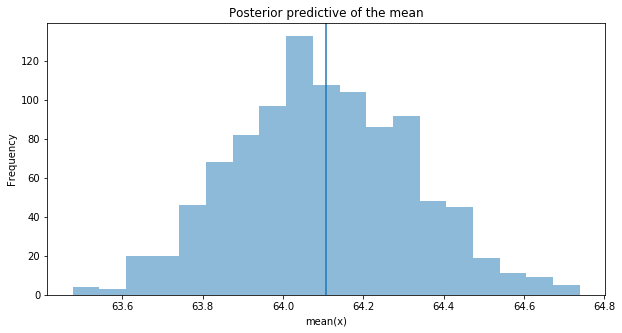

In [13]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)#ppc:predictive posterior check
print(np.asarray(ppc['y']).shape)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');